In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import os

In [ ]:
# ============================================
# USER INPUT SECTION
# ============================================

print("=" * 50)
print("   ETF PORTFOLIO ALLOCATOR")
print("=" * 50)

# Get risk profile from user
print("\nRisk Profile Options:")
print("  1 - Conservative (Low risk, mostly bonds)")
print("  2 - Balanced (Medium risk, mix of stocks & bonds)")
print("  3 - Aggressive (High risk, mostly stocks)")

choice = input("\nEnter your choice (1, 2, or 3): ")

profile_map = {'1': 'Conservative', '2': 'Balanced', '3': 'Aggressive'}

if choice not in profile_map:
    raise ValueError("Invalid choice! Please enter 1, 2, or 3")

risk_profile = profile_map[choice]

# Get investment amount from user
investment_input = input("\nEnter your investment amount in USD (e.g., 10000): $")
investment_amount = float(investment_input)

print(f"\n✅ Risk Profile: {risk_profile}")
print(f"✅ Investment Amount: ${investment_amount:,.2f}")

   ETF PORTFOLIO ALLOCATOR

Risk Profile Options:
  1 - Conservative (Low risk, mostly bonds)
  2 - Balanced (Medium risk, mix of stocks & bonds)
  3 - Aggressive (High risk, mostly stocks)


In [ ]:
# Define ETF allocation strategies for each risk profile
allocation_strategies = {
    'Conservative': {
        'BND': 50,   # Total Bond Market
        'VTIP': 20,  # Treasury Inflation-Protected
        'VTI': 15,   # US Total Market
        'VXUS': 10,  # International
        'GLD': 5     # Gold
    },
    'Balanced': {
        'SPY': 40,   # S&P 500
        'VTI': 30,   # US Total Market
        'BND': 20,   # Total Bond Market
        'GLD': 10    # Gold
    },
    'Aggressive': {
        'QQQ': 35,   # Nasdaq 100
        'VTI': 30,   # US Total Market
        'VXUS': 20,  # International
        'VWO': 10,   # Emerging Markets
        'GLD': 5     # Gold
    }
}

# Validate risk profile
if risk_profile not in allocation_strategies:
    raise ValueError(f"Invalid risk profile: '{risk_profile}'. Choose: Conservative, Balanced, or Aggressive")

print(f"✅ Selected Risk Profile: {risk_profile}")

✅ Selected Risk Profile: Balanced


In [ ]:
# Get allocation for selected profile
allocation = allocation_strategies[risk_profile]
etf_symbols = list(allocation.keys())

print(f"Fetching live data for: {etf_symbols}")

Fetching live data for: ['SPY', 'VTI', 'BND', 'GLD']


In [ ]:
# Fetch live ETF data from yfinance API
def fetch_etf_data(symbols):
    """Fetch current price and info for each ETF"""
    data = []
    
    for symbol in symbols:
        try:
            ticker = yf.Ticker(symbol)
            info = ticker.info
            hist = ticker.history(period='1d')
            
            current_price = hist['Close'].iloc[-1] if not hist.empty else info.get('regularMarketPrice', 'N/A')
            
            data.append({
                'Symbol': symbol,
                'Name': info.get('shortName', symbol),
                'Price': round(current_price, 2) if isinstance(current_price, (int, float)) else current_price,
                'Category': info.get('category', 'N/A')
            })
            print(f"  ✓ {symbol}: ${current_price:.2f}")
        except Exception as e:
            print(f"  ✗ {symbol}: Error fetching data")
            data.append({'Symbol': symbol, 'Name': symbol, 'Price': 'N/A', 'Category': 'N/A'})
    
    return pd.DataFrame(data)

print("\nFetching ETF data from yfinance API...\n")
etf_data = fetch_etf_data(etf_symbols)


Fetching ETF data from yfinance API...

  ✓ SPY: $694.07
  ✓ VTI: $342.40
  ✓ BND: $74.29
  ✓ GLD: $414.47


In [ ]:
# Build the portfolio allocation DataFrame
portfolio_df = pd.DataFrame({
    'Symbol': etf_symbols,
    'ETF Name': etf_data['Name'].values,
    'Allocation (%)': [allocation[s] for s in etf_symbols],
    'Current Price ($)': etf_data['Price'].values,
    'Category': etf_data['Category'].values
})

print(f"\n{'='*60}")
print(f"  {risk_profile.upper()} PORTFOLIO ALLOCATION")
print(f"  Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"{'='*60}\n")

portfolio_df


  BALANCED PORTFOLIO ALLOCATION
  Generated: 2026-01-12 08:13



,Symbol,ETF Name,Allocation (%),Current Price ($),Category
0,SPY,SPDR S&P 500,40,694.07,Large Blend
1,VTI,Vanguard Total Stock Market ETF,30,342.40,Large Blend
2,BND,Vanguard Total Bond Market ETF,20,74.29,Intermediate Core Bond
3,GLD,SPDR Gold Shares,10,414.47,Commodities Focused


In [ ]:
# Calculate investment amounts based on user input
portfolio_df['Investment ($)'] = (portfolio_df['Allocation (%)'] / 100 * investment_amount).round(2)

print(f"\n💰 Your ${investment_amount:,.2f} Portfolio Breakdown:\n")
for _, row in portfolio_df.iterrows():
    print(f"  {row['Symbol']:5} - ${row['Investment ($)']:,.2f} ({row['Allocation (%)']}%)")

print(f"\n  Total: ${portfolio_df['Investment ($)'].sum():,.2f}")


💰 Sample $10,000 Portfolio Breakdown:

  SPY   - $4,000.00 (40%)
  VTI   - $3,000.00 (30%)
  BND   - $2,000.00 (20%)
  GLD   - $1,000.00 (10%)

  Total: $10,000.00


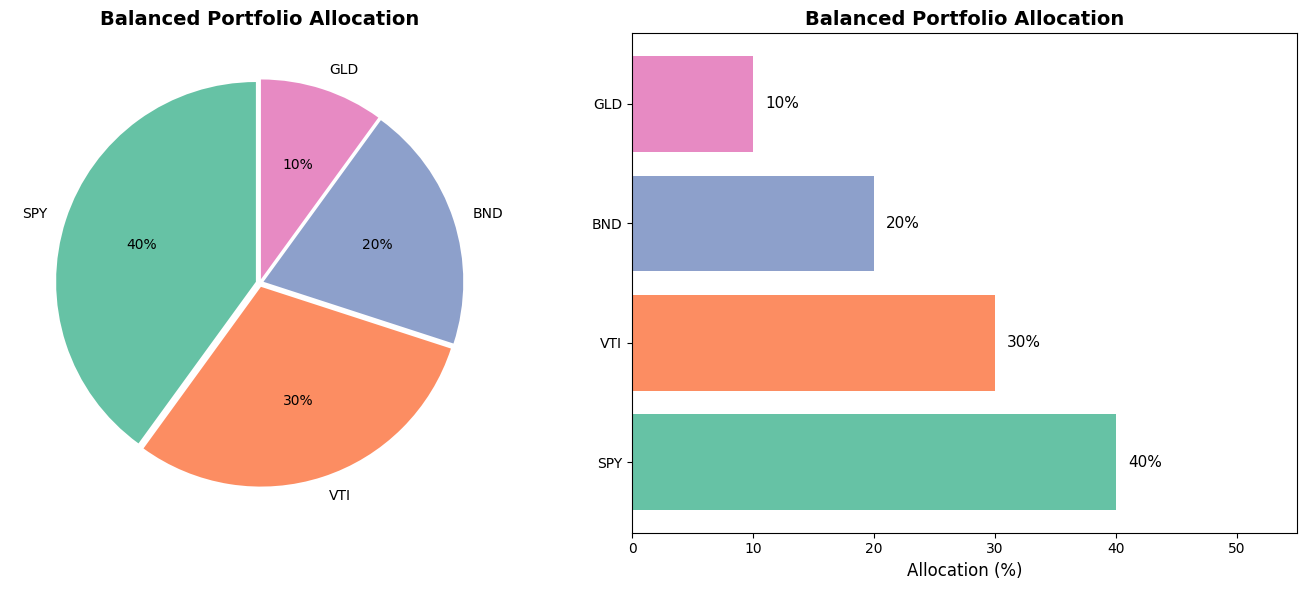


📊 Charts saved to: output/balanced_charts.png


In [ ]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = plt.cm.Set2(range(len(portfolio_df)))

# Pie Chart
axes[0].pie(
    portfolio_df['Allocation (%)'],
    labels=portfolio_df['Symbol'],
    autopct='%1.0f%%',
    colors=colors,
    startangle=90,
    explode=[0.02] * len(portfolio_df)
)
axes[0].set_title(f'{risk_profile} Portfolio Allocation', fontsize=14, fontweight='bold')

# Bar Chart
bars = axes[1].barh(portfolio_df['Symbol'], portfolio_df['Allocation (%)'], color=colors)
axes[1].set_xlabel('Allocation (%)', fontsize=12)
axes[1].set_title(f'{risk_profile} Portfolio Allocation', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 55)

for bar, val in zip(bars, portfolio_df['Allocation (%)']):
    axes[1].text(val + 1, bar.get_y() + bar.get_height()/2, f'{val}%', va='center', fontsize=11)

plt.tight_layout()
os.makedirs('output', exist_ok=True)
plt.savefig(f'output/{risk_profile.lower()}_charts.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Charts saved to: output/balanced_charts.png")

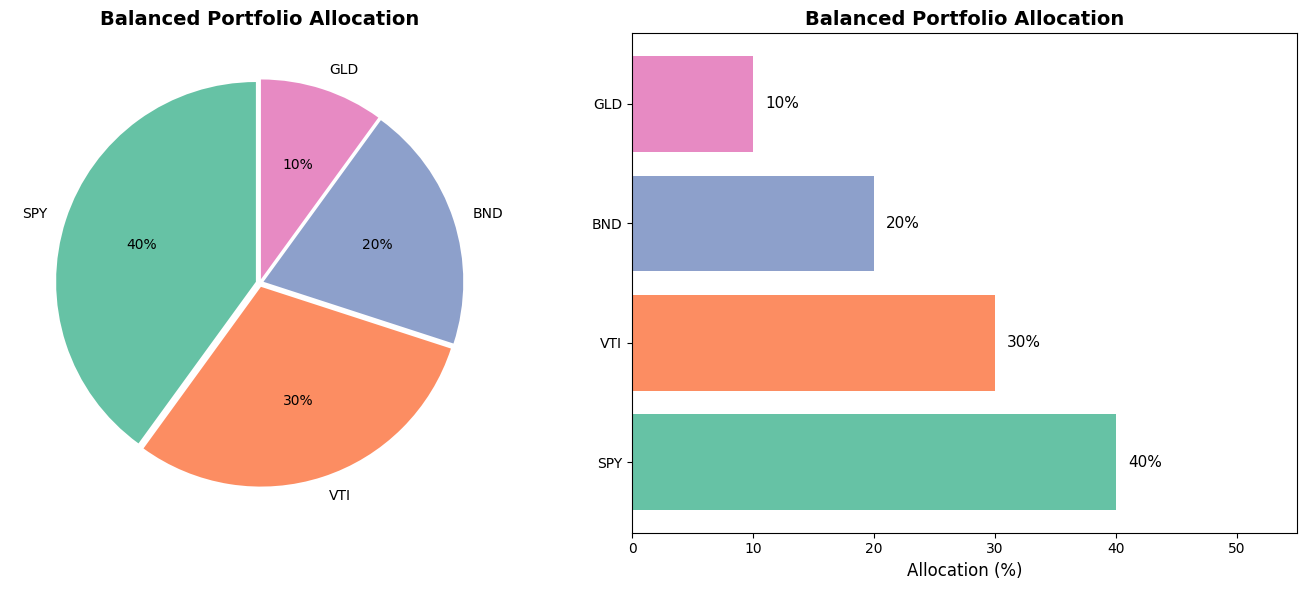


📊 Charts saved to: output/balanced_charts.png


In [ ]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = plt.cm.Set2(range(len(portfolio_df)))

# Pie Chart
axes[0].pie(
    portfolio_df['Allocation (%)'],
    labels=portfolio_df['Symbol'],
    autopct='%1.0f%%',
    colors=colors,
    startangle=90,
    explode=[0.02] * len(portfolio_df)
)
axes[0].set_title(f'{risk_profile} Portfolio Allocation', fontsize=14, fontweight='bold')

# Bar Chart
bars = axes[1].barh(portfolio_df['Symbol'], portfolio_df['Allocation (%)'], color=colors)
axes[1].set_xlabel('Allocation (%)', fontsize=12)
axes[1].set_title(f'{risk_profile} Portfolio Allocation', fontsize=14, fontweight='bold')
axes[1].set_xlim(0, 55)

for bar, val in zip(bars, portfolio_df['Allocation (%)']):
    axes[1].text(val + 1, bar.get_y() + bar.get_height()/2, f'{val}%', va='center', fontsize=11)

plt.tight_layout()
plt.savefig('output/balanced_charts.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Charts saved to: output/{risk_profile.lower()}_charts.png")

In [ ]:
# Save allocation to CSV
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

csv_filename = f'{risk_profile.lower()}_allocation.csv'
csv_path = os.path.join(output_dir, csv_filename)
portfolio_df.to_csv(csv_path, index=False)

print(f"\n✅ Portfolio allocation saved to: output/{csv_filename}")
print(f"\nCSV Preview:")
print(portfolio_df.to_string(index=False))


✅ Portfolio allocation saved to: output/balanced_allocation.csv

CSV Preview:
Symbol                        ETF Name  Allocation (%)  Current Price ($)               Category  Investment ($)
   SPY                    SPDR S&P 500              40             694.07            Large Blend          4000.0
   VTI Vanguard Total Stock Market ETF              30             342.40            Large Blend          3000.0
   BND  Vanguard Total Bond Market ETF              20              74.29 Intermediate Core Bond          2000.0
   GLD                SPDR Gold Shares              10             414.47    Commodities Focused          1000.0
